# Introduction
The goals / steps of this project are the following:
* Perform a HOG(Histogram of Oriented Gradients) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector.
* Implement a sliding-window techinique and use trained classifier to search for vehicles in images.
* Generation heat-map to create detected bound-box on vehicles and eliminate the false-positives in video.

In [1]:
%matplotlib inline
import numpy as np
import cv2
import os, time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
from helper import *

# Data preparation
Before we get on HOG feature extraction and trained classifier, we prepared the dataset first.
Udacity provided images of dataset for vehicles and non-vehicles.
* Number of Vehicle data is 8792 and non-vehicle is 8968, 
* It's pretty well balanced dataset. So, we don't use the data augmentation techniques.

In [4]:
vehicle_path = "./dataset/OwnCollection/vehicles/"
nonvehicle_path = "./dataset/OwnCollection/non-vehicles/"

In [5]:
vehicle_list = get_dataset(vehicle_path)
nonvehicle_list = get_dataset(nonvehicle_path)

In [6]:
len(vehicle_list), len(nonvehicle_list)

(8792, 8968)

In [7]:
ran_idx = np.random.randint(0, len(vehicle_list))
test_img = mpimg.imread(vehicle_list[ran_idx])
test_gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)

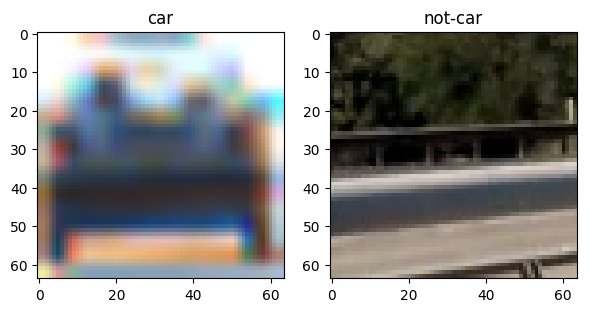

In [8]:
fig = plt.figure(dpi=100)
plt.subplot(121),plt.imshow(test_img),plt.title('car')
plt.subplot(122),plt.imshow(mpimg.imread(nonvehicle_list[ran_idx])),plt.title('not-car')
fig.tight_layout()

# Feature extraction
We prepared the dataset and before the train the classifier, we need to get features using several extraction methods(HOG, Binned color and Color histogram).

I combined these mutiple features, here are some extration results below:

## HOG (Histogram of Oriented Gradients)

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


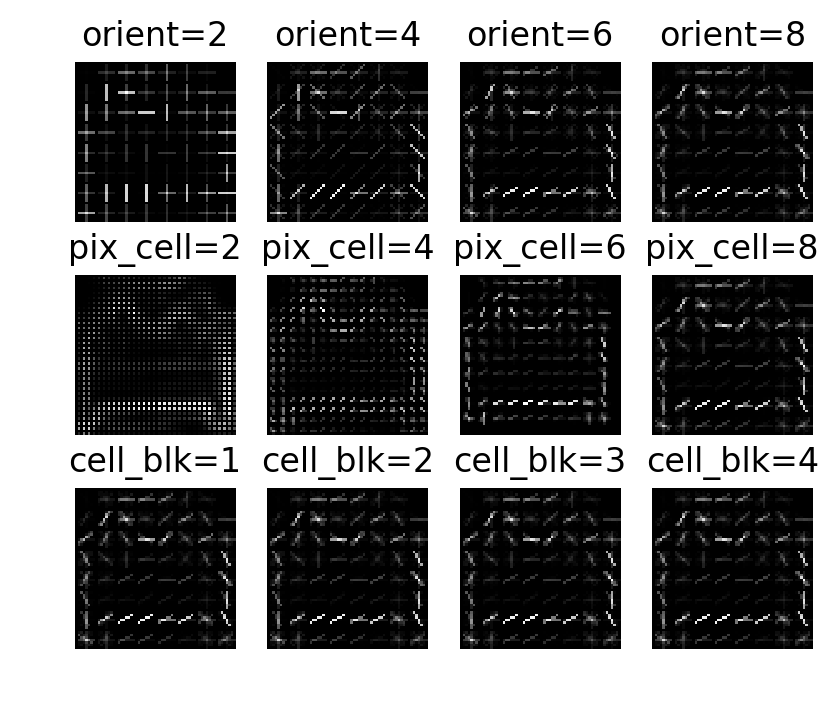

In [9]:
plt.figure(dpi=200)
for i in range(1,5):
    hog_features, hog_image = get_hog_features(test_gray, orient=i*2, pix_per_cell=8, cell_per_block=2, vis=True)
    plt.subplot(3,5,i+1), plt.imshow(hog_image, cmap='gray'),plt.axis('off'),plt.title("orient=" + str(i*2))
    hog_features, hog_image = get_hog_features(test_gray, orient=8, pix_per_cell=i*2, cell_per_block=2, vis=True)
    plt.subplot(3,5,i+5+1), plt.imshow(hog_image, cmap='gray'),plt.axis('off'),plt.title("pix_cell=" + str(i*2))
    hog_features, hog_image = get_hog_features(test_gray, orient=8, pix_per_cell=8, cell_per_block=i, vis=True)
    plt.subplot(3,5,i+10+1), plt.imshow(hog_image, cmap='gray'),plt.axis('off'),plt.title("cell_blk=" + str(i))
        

## Binned color

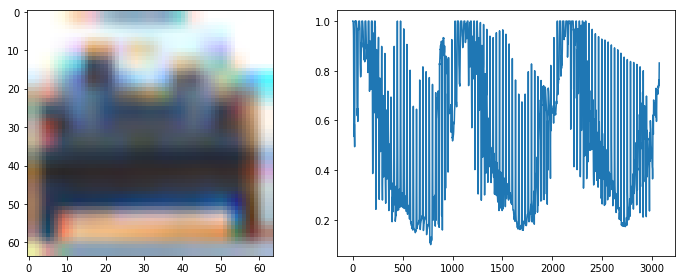

In [10]:
from matplotlib import gridspec

fig = plt.figure(figsize=(10, 4)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
ax0.imshow(test_img)
ax1 = plt.subplot(gs[1])
ax1.plot(bin_spatial(test_img))

plt.tight_layout()

## Color histogram

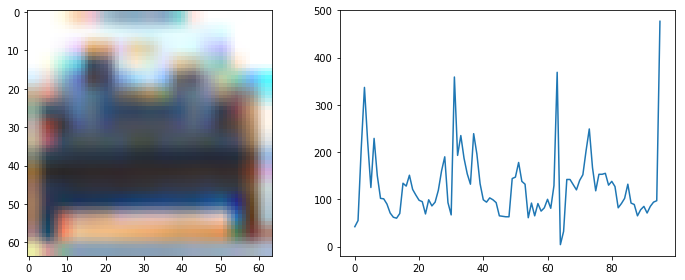

In [11]:
fig = plt.figure(figsize=(10, 4)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
ax0.imshow(test_img)
ax1 = plt.subplot(gs[1])
ax1.plot(color_hist(test_img))

plt.tight_layout()

## Parameter tuning
To get effective classifier, I tested classifier accuracy with combination of the parameters below.
* color space : ('RGB', 'LUV','HLS','YCrCb')
* orient : (9, 12)
* pix_per_cell : (8, 16)
* cell_per_block : (1, 2)

I finalized the parameter values for below based on test results. I think it looks best effective set of parameters. It takes 6.64 Seconds to train SVC and test accuracy of SVC is 0.9935.
Here is [Tuning result](SVC-Classifier-Parameter-tune).

I combined with mutiple features(HOG, color histogram and binned color) and noamlize it using 'sklearn.preprocessing.StandardScaler'. The datasets randomly seperated to validate the dataset.

In [12]:
# Parameter choised
color_space = 'YCrCb'   # Can be RGB, HSV, LUV, *HLS, YUV, YCrCb
orient = 12            #32 # HOG orientations
pix_per_cell = 8      #16 # HOG pixels per cell
cell_per_block = 2    #2 # HOG cells per block
hog_channel = 'ALL'   # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32)  #(8, 8) # Spatial binning dimensions
hist_bins =  32        #8 # Number of histogram bins
spatial_feat = True   # Spatial features on or off
hist_feat = True      # Histogram features on or off
hog_feat = True       # HOG features on or off

In [13]:
# Extract features from cars and non-cars
car_features = extract_features(vehicle_list, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(nonvehicle_list, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [14]:
# Dataset preprocessing, Normalization
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=ran_idx)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd7ac589588>,
 Text(0.5,1,'Starndardized'),
 ([], <a list of 0 Text xticklabel objects>))

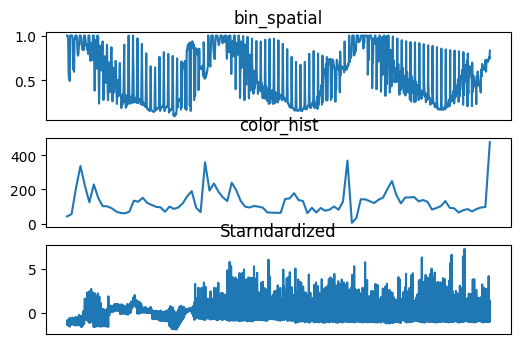

In [16]:
fig = plt.figure(dpi=100)
plt.subplot(311),plt.plot(bin_spatial(test_img)),plt.title('bin_spatial'),plt.xticks([])
plt.subplot(312),plt.plot(color_hist(test_img)),plt.title('color_hist'),plt.xticks([])
plt.subplot(313),plt.plot(X_train[ran_idx]),plt.title('Starndardized'),plt.xticks([])


# Classifier
Next, we can train the classifier. I used Linear Support Vector Classifier using 'sklearn.svm.LinearSVC'. The tuning parameters for SVC were used as default values.

In [17]:
svc = LinearSVC()

t=time.time()
svc.fit(X_train, y_train)
t2=time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


7.71 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


In [18]:
print(svc)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


# Search the window

## hog_subsample
Instead of using sliding window approach, define a single function that can extract features using hog sub-sampling and make predictions directly.

The codes below only has to extract hog features once and then can get all of its overlaying windows. Each windows is defined by a scale factor. A scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance.

Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

In [19]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bbox = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1,-1)
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1,-1)
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1,-1)
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_features = X_scaler.transform(hog_features).reshape(1,-1)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = [(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)]
                cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 6)                
                bbox.append(box)
    return bbox, draw_img#, hog_features, spatial_features, hist_features

In [20]:
ystart = 400
ystop = 656
scale = 1.5
test_img = mpimg.imread('./test_images/test1.jpg')
# test_img = cv2.imread('./test_images/test1.jpg')

In [21]:
# find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
testbbox, draw_img = find_cars(img=test_img,
                               ystart=ystart,
                               ystop=ystop,
                               scale=scale,
                               svc=svc,
                               X_scaler=X_scaler,
                               orient=orient,
                               pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block,
                               spatial_size=spatial_size,
                               hist_bins=hist_bins)

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


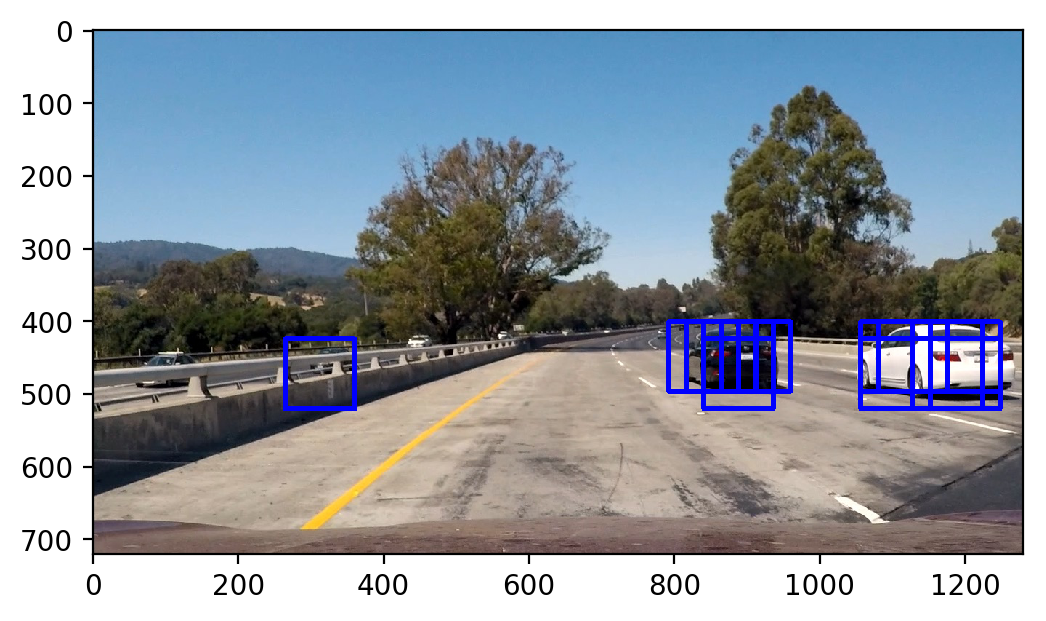

In [22]:
plt.figure(dpi=200)
plt.imshow(draw_img)

## Find the windows for different scale
I defined scale factors as [1.1, 1.4, 1.8, 2.4, 2.9, 3.4]. The scale factor with less than 1.0 can get results detecting well in far distance objects(The small objects means far away), but It brings many false-positives. And larger than 1.0 can reduced false-positives but the accuracy of the far distance objects was decreased.

In [23]:
def find_cars_multiple_scale(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    scales = [1.1, 1.4, 1.8, 2.4, 2.9, 3.4]
    #scales = [0.5, 0.7, 1.1, 2.0]
    #scales = [1.5, 2.0]
    bbox_list = []
    bboxs = []           
    for scale in scales:
        #The first half of scales is valid for the upper half of image
        #box,draw_img, = find_cars(img, ystart,ystop,scale,svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins)
        box, draw_img = find_cars(img=img,
                                   ystart=ystart,
                                   ystop=ystop,
                                   scale=scale,
                                   svc=svc,
                                   X_scaler=X_scaler,
                                   orient=orient,
                                   pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   spatial_size=spatial_size,
                                   hist_bins=hist_bins)
        bboxs.append(box)
        
    for i in range(len(bboxs)):
        for bbox in bboxs[i]:
            bbox_list.append(bbox)
            
    return bbox_list

In [24]:
out_bbox = find_cars_multiple_scale(test_img,ystart,ystop,svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins)
len(out_bbox), out_bbox

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(57,
 [[(52, 435), (122, 505)],
  [(70, 435), (140, 505)],
  [(140, 435), (210, 505)],
  [(264, 417), (334, 487)],
  [(281, 417), (351, 487)],
  [(809, 400), (879, 470)],
  [(827, 400), (897, 470)],
  [(827, 417), (897, 487)],
  [(844, 400), (914, 470)],
  [(844, 417), (914, 487)],
  [(862, 400), (932, 470)],
  [(862, 417), (932, 487)],
  [(862, 435), (932, 505)],
  [(880, 400), (950, 470)],
  [(880, 417), (950, 487)],
  [(880, 435), (950, 505)],
  [(1056, 417), (1126, 487)],
  [(1056, 435), (1126, 505)],
  [(1073, 417), (1143, 487)],
  [(1073, 435), (1143, 505)],
  [(1091, 417), (1161, 487)],
  [(1126, 417), (1196, 487)],
  [(1126, 435), (1196, 505)],
  [(1144, 400), (1214, 470)],
  [(1144, 417), (1214, 487)],
  [(1144, 435), (1214, 505)],
  [(1144, 452), (1214, 522)],
  [(1161, 400), (1231, 470)],
  [(1161, 417), (1231, 487)],
  [(1179, 417), (1249, 487)],
  [(1179, 435), (1249, 505)],
  [(44, 422), (133, 511)],
  [(67, 422), (156, 511)],
  [(806, 400), (895, 489)],
  [(828, 400), (9

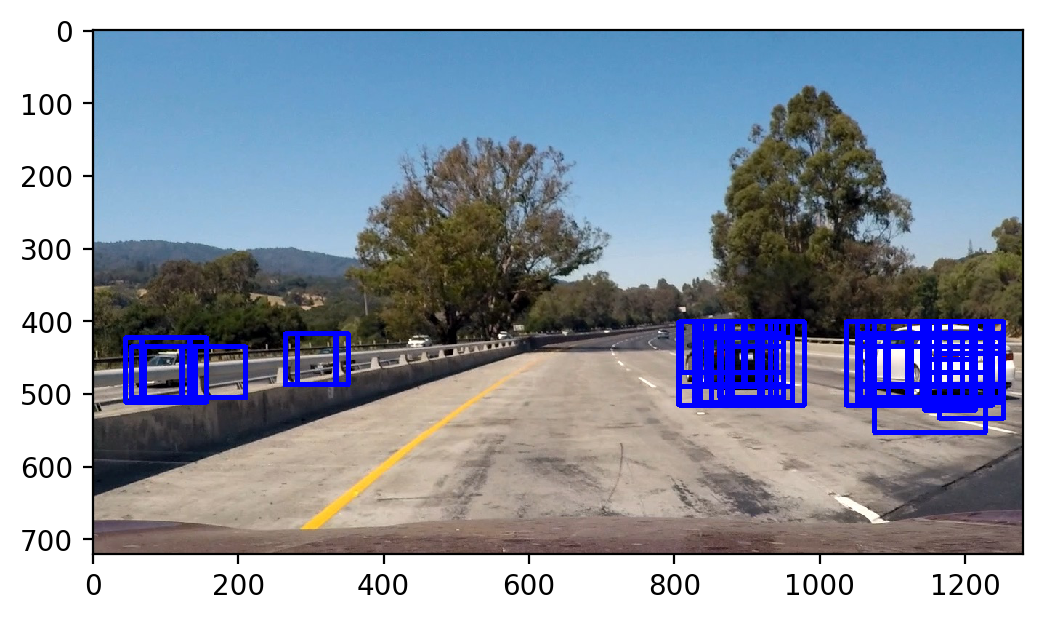

In [25]:
# Plot multi-scaled bounding-box
imcopy = np.copy(test_img)
for bbox in out_bbox:
        cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255),6)

plt.figure(dpi=200)
plt.imshow(imcopy)

## Generate heat-map
Here are test frames from the project images and I'm showing all the bounding boxes for where my classifier reported positive detections. You can see that overlapping detections exist for each of the two vehicles, I find a false positive detection on the guardrail to the left. In this case, we need a heat-map approach from these detections in order to combine overlapping detections and remove false positives.

In [26]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    bbox_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
        bbox_list.append(bbox)
    # Return the image
    return img, bbox_list

def get_heatmap(img ,box_list,threshold=1, showImg = True):
    draw_img = np.copy(img)
    heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list=box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img,lbl_heat = draw_labeled_bboxes(draw_img,labels)
    
    if showImg ==  True:
        return draw_img, heatmap, lbl_heat
    else:
        return heatmap, lbl_heat

[((809, 400), (961, 514)), ((1052, 400), (1252, 521)), ((67, 435), (132, 504))]

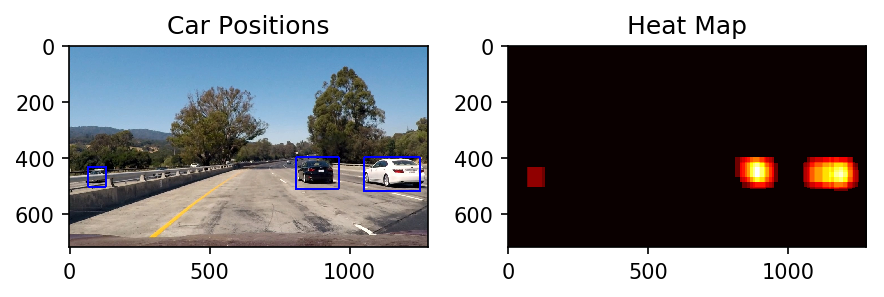

In [27]:
draw_img, heatmap, heatmap_bbox_list = get_heatmap(test_img, out_bbox, threshold=2)

fig = plt.figure(dpi=150)
plt.subplot(221),plt.imshow(draw_img),plt.title('Car Positions')
plt.subplot(222),plt.imshow(heatmap, cmap='hot'),plt.title('Heat Map')

fig.tight_layout()
heatmap_bbox_list

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


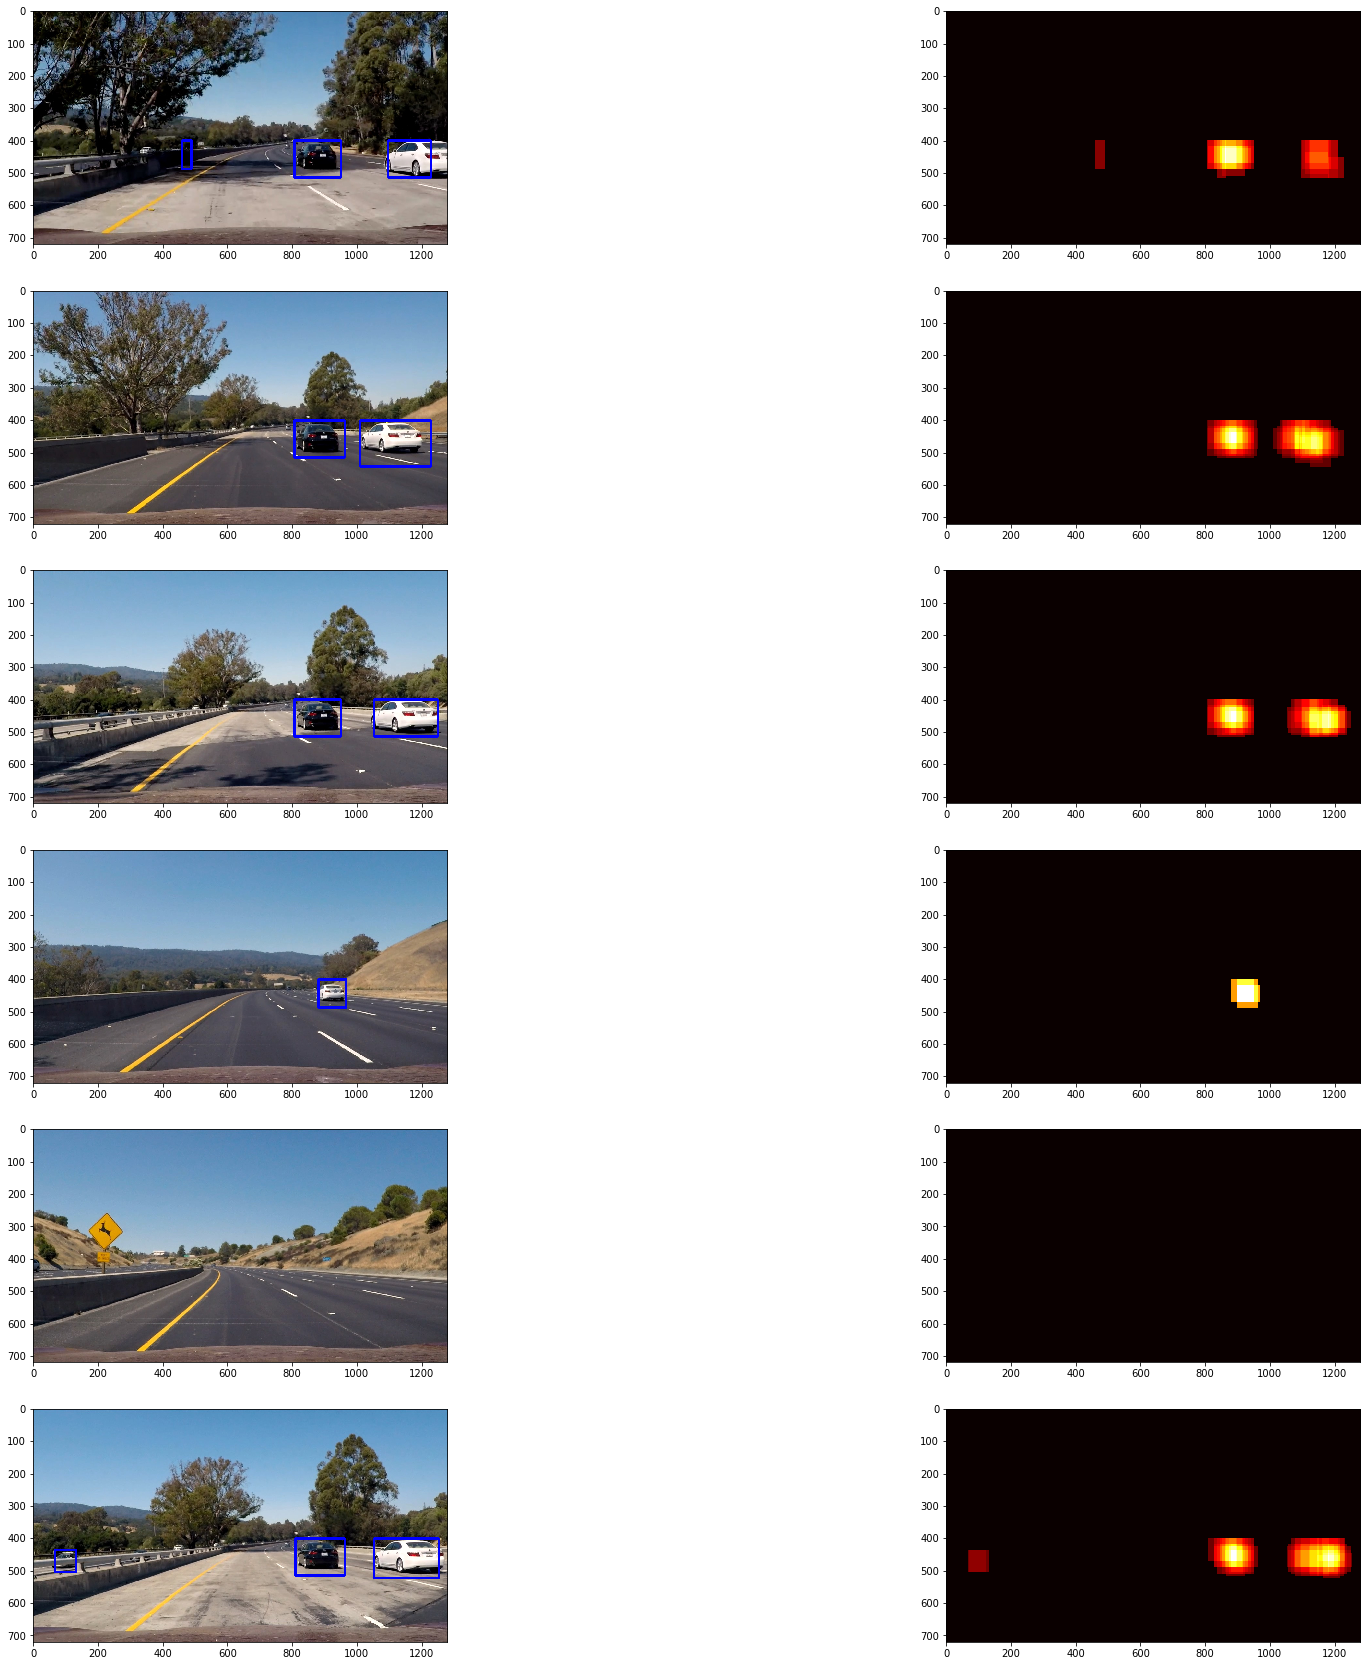

In [28]:
test_images = glob.glob('./test_images/test*.jpg')

plt_idx = 0
plt.figure(figsize = (30,30))
gs1 = gridspec.GridSpec(len(test_images), 2, width_ratios=[1,1])

for img_path in test_images:
    # Load Image in uint8 type
    img = mpimg.imread(img_path)
    # Find the multi-scaled bounding-box
    out_bbox = find_cars_multiple_scale(img,ystart,ystop,svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins)
    # Generate the heatmap
    draw_img, heatmap, heatmap_bbox_list = get_heatmap(img, out_bbox, threshold=2)
    
    ax1 = plt.subplot(gs1[plt_idx])
    ax1.imshow(draw_img)
    ax1 = plt.subplot(gs1[plt_idx+1])
    ax1.imshow(heatmap, cmap='hot')
    
    plt_idx += 2

## Eliminate False Positives
We can reduced the false positives using heat-map and overlay threshold methods, but still we need more robust method.

we will integrate a heat map over several frames of video, such that areas of multiple detections get "hot", while transient false positives stay "cool". You can then simply threshold your heatmap to remove false positives.

Here is the frame interpolation results below:

In [29]:
def process_image_single_frame(img):
    # Find the multi-scaled bounding-box
    out_bbox = find_cars_multiple_scale(img,ystart,ystop,svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins)
    
    # Generate the heatmap
    draw_img, heatmap, heatmap_bbox_list = get_heatmap(img, out_bbox, threshold=4)
    
    return draw_img

In [30]:
n_frames = 10
smooth_thres = 5
smooth_average = 3
bbox_frames = []
counter = 0

In [31]:
n_frames = 10
smooth_thres = 2
smooth_average = 2
bbox_frames = []
counter = 0

In [32]:
for _ in range(n_frames):
    bbox_frames.append(0)

def process_image(img):
    global counter
    global bbox_frames
    

    counterFrame = counter % n_frames
        
    # Find the multi-scaled bounding-box
    out_bbox = find_cars_multiple_scale(img,ystart,ystop,svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins)
    
    # Generate the heatmap
    _, heatmap, heatmap_bbox_list = get_heatmap(img, out_bbox, threshold=smooth_thres)
    
    if counter < n_frames:
        bbox_frames[counter] = heatmap_bbox_list
        
    else:
        bbox_frames.pop(0)
        bbox_frames.append(heatmap_bbox_list)
    
    #bbox_frames[counterFrame] = heatmap_bbox_list
    
    
    bbox2=[]
    for box in bbox_frames:
        if box!=0:
            for b in box:
                bbox2.append(b)
                
    draw_img, heatmap, heatmap_bbox_list = get_heatmap(img, bbox2, threshold=smooth_average)
    
    counter +=1
    
    return draw_img

# Video results

In [33]:
from moviepy.editor import VideoFileClip
import time

In [34]:
output1 = 'out_test_video.mp4'
clip1 = VideoFileClip("./test_video.mp4")
out_clip1 = clip1.fl_image(process_image)
# out_clip1 = clip1.fl_image(process_image_single_frame)
%time out_clip1.write_videofile(output1, audio=False)

[MoviePy] >>>> Building video out_test_video.mp4
[MoviePy] Writing video out_test_video.mp4


 97%|█████████▋| 38/39 [01:06<00:01,  1.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test_video.mp4 

CPU times: user 1min 5s, sys: 724 ms, total: 1min 6s
Wall time: 1min 6s


In [37]:
output = 'out_project_video.mp4'
clip = VideoFileClip("./project_video.mp4")#.subclip(20,25)
out_clip = clip.fl_image(process_image)
# out_clip = clip.fl_image(process_image_single_frame)
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|█████████▉| 1260/1261 [37:00<00:01,  1.76s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

CPU times: user 36min 40s, sys: 8.49 s, total: 36min 49s
Wall time: 37min 1s


# Conclusion
On this project we detected vehicles using machine learning approaches. Here is the basic pipeline below:
1. Feature extraction.
1. Train the classifier
1. Sliding windows and find the vehicle detected region
1. Make the heat-map and eliminate false positives

We took the unique features from images of vehicle and non-vehicle  using feature extraction method(hog, color histogram and binned color) and combined it. After got features we trained linear support vector classifier. The parameters tuned by several tests results. Instead of using sliding window approach, define a single function that can extract features using hog sub-sampling and make predictions directly. We can reduced the false positives using heat-map and overlay threshold methods. And we will integrate a heat map over several frames of video, to get more robust result, such that areas of multiple detections get "hot", while transient false positives stay "cool". we can then vehicle detection program robust on false positives.

### issues
1. Still we have false-positives.
1. Heavy computation for sliding window method.

### Improvements
1. Consider Deep learning classifier : If we use deep learning classifier(CNN), we can get unique features and probabilities of prediction. In my case, the final detection results were severely affected by feature extrator's performance. For this reason, deep learning classifier can improve the detection accuracy.
1. Sliding window free approach : We can take ideas from Yolo, Single Shot multibox Detector which is based on region free method. And generally this will get result faster than sliding window method.

# Reference
* Udacity SDC nanodegree P4 lesson scripts.
* https://chatbotslife.com/vehicle-detection-and-tracking-using-computer-vision-baea4df65906
* https://github.com/hortovanyi/udacity-vehicle-detection-project